# Non-linear Matrix Factorization with Gaussian Processes

This is an attempt to reproduce [this ICML 2009 paper](http://people.ee.duke.edu/~lcarin/MatrixFactorization.pdf).

In [1]:
import tensorflow as tf
DEVICE = "/cpu:0"

In [2]:
N = 100  # items
D = 2071  # users
q = 10  # latent dimension

In [3]:
# Simulated data
import numpy as np
from sklearn.preprocessing import scale

def get_simulated_data(true_alpha_x=5, true_alpha_w=2, true_sigma=1):
    X = np.random.randint(50, size=(N, q))
    #X = np.random.normal(0, 1/true_alpha_x, (N, q))
    W = np.random.normal(0, 1/true_alpha_w, (D, q))
    rating_rows = []
    for i in range(N):
        rating_rows.append(np.random.multivariate_normal(W.dot(X[i, :]), true_sigma ** 2 * np.eye(D)))
    Y = np.array(rating_rows)
    Y_scaled = scale(Y, axis=1, with_std=False)
    return Y, Y_scaled

In [4]:
# Real data
from mangaki.algo.dataset import Dataset
from mangaki.utils.values import rating_values

dataset = Dataset()
dataset.load_csv('ratings-ordered.csv', convert=lambda choice: rating_values[choice])

In [5]:
from scipy.sparse import coo_matrix

rows = dataset.anonymized.X[:, 0]
cols = dataset.anonymized.X[:, 1]
data = dataset.anonymized.y
mangaki = coo_matrix((data, (rows, cols)), shape=(dataset.anonymized.nb_users, dataset.anonymized.nb_works)).tocsr()

In [7]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

Now skip to ALS.

In [132]:
mangaki[:, :100]

<2071x100 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [133]:
Y = mangaki[:, :100].tocoo().T.tocsr()
for movie_id in range(N):
    row = Y[movie_id, :]
    for user_id, replace in zip(row.indices, scale(row.data)):
        Y[movie_id, user_id] = replace

In [134]:
dataset = coo_matrix(Y)
#dataset = coo_matrix(Y_scaled)

In [135]:
Y

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [136]:
# Prepare batches
from sklearn.model_selection import ShuffleSplit

# Simple split
splitter = ShuffleSplit(n_splits=1, test_size=0.2)
for i_train, i_test in splitter.split(dataset.data):
    train = coo_matrix((dataset.data[i_train], (dataset.row[i_train], dataset.col[i_train])), shape=(N, D)).tocsc()
    test = coo_matrix((dataset.data[i_test], (dataset.row[i_test], dataset.col[i_test])), shape=(N, D)).tocsc()

# Split by user
train_data = []
train_row = []
train_col = []
test_data = []
test_row = []
test_col = []
full = dataset.tocsc()
nb_skip = 0
train_users = set(range(D))
for user_id in range(D):
    this_user = full[:, user_id]
    N_j = this_user.getnnz()
    if N_j <= q:
        train_users.remove(user_id)
        nb_skip += 1
        continue
    for i_train, i_test in splitter.split(this_user.indices):
        train_col.extend([user_id] * len(i_train))
        train_row.extend(this_user.indices[i_train])
        train_data.extend(this_user.data[i_train])
        test_col.extend([user_id] * len(i_test))
        test_row.extend(this_user.indices[i_test])
        test_data.extend(this_user.data[i_test])
print('nb users skipped', nb_skip, 'over', D)

nb users skipped 465 over 2071


In [137]:
assert len(train_data) == len(train_row)
assert len(test_data) == len(test_row)

In [138]:
train = coo_matrix((train_data, (train_row, train_col)), shape=(N, D)).tocsc()
test = coo_matrix((test_data, (test_row, test_col)), shape=(N, D)).tocsc()

In [139]:
train

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 60093 stored elements in Compressed Sparse Column format>

In [140]:
test

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 15842 stored elements in Compressed Sparse Column format>

In [141]:
item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
rate_batch = tf.placeholder(tf.float32, shape=[None, None], name="rate")
pred_batch = tf.placeholder(tf.int32, shape=[None], name="id_pred")

In [142]:
def log_det(cov):
    return 2 * tf.reduce_sum(tf.log(tf.diag_part(tf.cholesky(cov))))

In [146]:
def kernel(X, Y):
    return tf.matmul(X, tf.transpose(Y))

class MFGP:
    def __init__(self):
        with tf.device(DEVICE):
            with tf.variable_scope("conv1"):
                self.sigma = tf.Variable(1e-1, name="sigma")  # tf.random_normal([1])
                self.alpha_w = tf.Variable(tf.random_normal([1]), name="alpha_w")
                self.X_item = tf.Variable(tf.random_normal([N, q], stddev=5), name="embd_item")

    def predict(self, item_batch, rate_batch, pred_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            X_pred = tf.nn.embedding_lookup(self.X_item, pred_batch)
            N_j = tf.shape(item_batch)[0]
            cov = kernel(X_batch, X_batch) + self.sigma ** 2 * tf.eye(N_j)
            s = tf.matmul(tf.matrix_inverse(cov), kernel(X_batch, X_pred))
            prediction = tf.matmul(tf.transpose(s), rate_batch)
        return tf.reshape(prediction, [-1])

    def get_loss(self, item_batch, rate_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            XT_batch = tf.transpose(X_batch)
            N_j = tf.shape(item_batch)[0]
            defpos = kernel(X_batch, X_batch)
            cov = 1/tf.abs(self.alpha_w) * defpos + self.sigma ** 2 * tf.eye(N_j)
            # inv_cov = tf.matrix_inverse(cov)  # O(N_j^3)
            cheap_inv = tf.matrix_inverse(tf.abs(self.alpha_w) * self.sigma ** (-2) * tf.eye(q)
                                          + tf.matmul(XT_batch, X_batch))
            inv_cov = self.sigma ** (-2) - self.sigma ** (-4) * tf.matmul(X_batch, tf.matmul(cheap_inv, XT_batch))  # O(q^3)
            loss = (tf.cast(N_j, tf.float32) * log_det(cov)
                    + tf.reshape(tf.matmul(tf.transpose(rate_batch), tf.matmul(inv_cov, rate_batch)), []))
        return loss, (cov, defpos, X_batch)

    def optimization(self, item_batch, rate_batch, learning_rate):
        global_step = tf.train.get_global_step()
        assert global_step is not None
        with tf.device(DEVICE):
            loss, (cov, defpos, X_batch) = self.get_loss(item_batch, rate_batch)
            train_op = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True).minimize(loss, global_step=global_step, var_list=[self.X_item])
        return loss, train_op, (cov, defpos, X_batch)

In [147]:
def to_matrix(l):
    return np.array(l).reshape(len(l), 1)

In [148]:
from sklearn.metrics import mean_squared_error
from collections import deque
import time
import random
import sys

mfgp = MFGP()
prediction = mfgp.predict(item_batch, rate_batch, pred_batch)

global_step = tf.contrib.framework.get_or_create_global_step()
loss, train_op, (cov, defpos, X_batch) = mfgp.optimization(item_batch, rate_batch, learning_rate=0.0001)

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    print(" | ".join(["user_id", "epoch", "train_error", "val_error", "elapsed_time"]))
    errors = []
    for epoch in range(50):
        cross = list(train_users)
        random.shuffle(cross)
        train_preds = []
        train_ratings = []
        for user_id in cross:
            train_batch = train[:, user_id]
            if train_batch.getnnz() == 0:
                continue
            items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
            try:
                sess.run(train_op, feed_dict={item_batch: items_rated,
                                              rate_batch: ratings,
                                              pred_batch: items_rated})
            except Exception as e:
                print('Error for %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                print('Sigma', mfgp.sigma.eval(), 'alpha_w', mfgp.alpha_w.eval())
                print(sess.run([tf.shape(X_batch), X_batch], feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(defpos), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(cov), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(e.message)
                print(sys.exc_info()[0].__doc__)

        # End of train epoch, start test
        if epoch % 1 == 0:
            total_nll = []
            test_truth = []
            test_preds = []
            for user_id in train_users:
                train_batch = train[:, user_id]
                test_batch = test[:, user_id]
                items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
                items_to_pred, truth = test_batch.indices, test_batch.data
                try:
                    this_user_nll, train_pred = sess.run([loss, prediction], feed_dict={item_batch: items_rated,
                                                                                        rate_batch: ratings,
                                                                                        pred_batch: items_rated})
                except:
                    print('Error for train %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                try:
                    test_pred = sess.run(prediction, feed_dict={item_batch: items_rated,
                                                                rate_batch: ratings,
                                                                pred_batch: items_to_pred})
                except:
                    print('Error for test %d (%s): %s' % (user_id, str(items_to_pred), sys.exc_info()[0]))
                total_nll.append(this_user_nll)
                train_ratings.extend(ratings)
                train_preds.extend(train_pred)
                test_truth.extend(truth)
                test_preds.extend(test_pred)
            train_rmse = np.sqrt(mean_squared_error(train_ratings, train_preds))            
            train_stupid = np.sqrt(mean_squared_error(train_ratings, [0] * len(train_ratings)))            
            test_rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
            test_stupid = np.sqrt(mean_squared_error(test_truth, [0] * len(test_truth)))
            print("epoch={:3d} train_rmse={:f} ({:f}) test_rmse={:f} ({:f}) total_nll={:f} sigma={:f} alpha_w={:f}"
                  .format(epoch, train_rmse, train_stupid, test_rmse, test_stupid,
                          sum(total_nll), abs(float(mfgp.sigma.eval())), abs(float(mfgp.alpha_w.eval()))))
    print('learned sigma')
    print(mfgp.sigma.eval())
    print('learned alpha_w')
    print(mfgp.alpha_w.eval())
    print('learned x')
    print(mfgp.x_item.eval())

user_id | epoch | train_error | val_error | elapsed_time
epoch=  0 train_rmse=7.099235 (1.000710) test_rmse=6.157351 (1.003259) total_nll=-287224265.353516 sigma=0.100000 alpha_w=1.753959
epoch=  1 train_rmse=2.079178 (1.000710) test_rmse=2.118881 (1.003259) total_nll=-298726846.699219 sigma=0.100000 alpha_w=1.753959
epoch=  2 train_rmse=11.680286 (1.000710) test_rmse=9.852969 (1.003259) total_nll=-302750440.118164 sigma=0.100000 alpha_w=1.753959
epoch=  3 train_rmse=19.395447 (1.000710) test_rmse=15.919051 (1.003259) total_nll=-304895133.985352 sigma=0.100000 alpha_w=1.753959
epoch=  4 train_rmse=27.530071 (1.000710) test_rmse=28.348537 (1.003259) total_nll=-306099596.312500 sigma=0.100000 alpha_w=1.753959
epoch=  5 train_rmse=9.603479 (1.000710) test_rmse=9.229228 (1.003259) total_nll=-307085520.960938 sigma=0.100000 alpha_w=1.753959


KeyboardInterrupt: 

(The error is because it was interrupted.)

As you can see, the learning stops when the stupid RMSE (every prediction is 0) is obtained.

# Meanwhile, Alternating Least Squares…

In [8]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

In [9]:
mangaki.data[:10]

array([ 2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  0.1,  2. ,  0.1])

In [10]:
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(n_splits=1, test_size=0.2)
X_train = []
y_train = []
X_test = []
y_test = []
for i_train, i_test in splitter.split(range(D)):
    i_train = set(i_train)
    i_test = set(i_test)
    for (user_id, work_id), rating in zip(dataset.anonymized.X, dataset.anonymized.y):
        if user_id in i_train:
            X_train.append((user_id, work_id))
            y_train.append(rating)
        else:
            X_test.append((user_id, work_id))
            y_test.append(rating)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
len(X_train), len(X_test)

(266843, 66804)

In [12]:
from mangaki.algo.als import MangakiALS

def compute_all_errors(X_train, y_train, X_test, y_test):
    y_train_pred = als.predict(X_train)
    print('Train RMSE=', als.compute_rmse(y_train, y_train_pred))
    y_test_pred = als.predict(X_test)
    print('Test RMSE=', als.compute_rmse(y_test, y_test_pred))

als = MangakiALS()
als.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
als.fit(X_train, y_train)
compute_all_errors(X_train, y_train, X_test, y_test)

Computing M: (2071 × 10086)
Chrono: fill and center matrix [0q, 781ms]
Shapes (2071, 20) (20, 10086)
Chrono: factor matrix [0q, 6151ms]
Train RMSE= 0.897150508249
Test RMSE= 1.77297204593


In [47]:
y_pred = als.predict(X_train)
(y_train - y_pred).std()

0.89709726128860334

And the learned rows of $U$ seem Gaussian!

(array([   2.,   22.,  110.,  536.,  702.,  423.,  212.,   60.,    3.,    1.]),
 array([-1.15588791, -0.85998928, -0.56409066, -0.26819203,  0.0277066 ,
         0.32360523,  0.61950386,  0.91540249,  1.21130112,  1.50719975,
         1.80309838]),
 <a list of 10 Patch objects>)

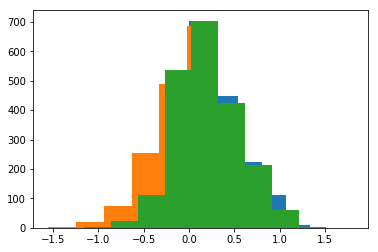

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.U[:, 0])
plt.hist(als.U[:, 1])
plt.hist(als.U[:, 15])

(array([  1.00000000e+00,   6.00000000e+00,   4.80000000e+01,
          4.33000000e+02,   2.23500000e+03,   5.08400000e+03,
          1.64900000e+03,   5.25000000e+02,   9.70000000e+01,
          8.00000000e+00]),
 array([-1.74293509, -1.41205609, -1.08117708, -0.75029808, -0.41941907,
        -0.08854007,  0.24233894,  0.57321794,  0.90409694,  1.23497595,
         1.56585495]),
 <a list of 10 Patch objects>)

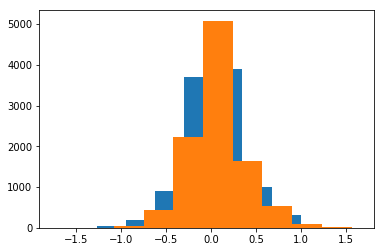

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.VT.T[:, 17])
plt.hist(als.VT.T[:, 5])

Maybe it does not hold for $V$.

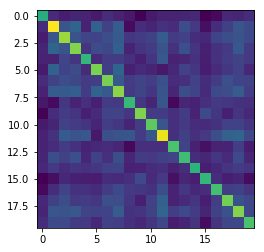

In [16]:
%matplotlib inline

cov = np.cov(als.U.T)
plt.imshow(cov)

In [17]:
np.diag(cov)

array([ 0.11225514,  0.1733645 ,  0.1489047 ,  0.14254672,  0.11873304,
        0.14107898,  0.13984785,  0.14497964,  0.12017469,  0.14221501,
        0.13320248,  0.16844708,  0.12730341,  0.12307339,  0.11632435,
        0.1183549 ,  0.12517339,  0.13908909,  0.14348131,  0.12675317])

In [18]:
als.U.shape

(2071, 20)

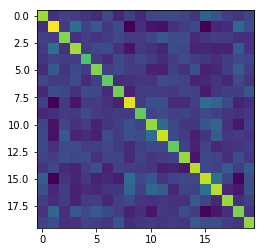

In [19]:
%matplotlib inline

cov = np.cov(als.VT)
plt.imshow(cov)

In [20]:
np.diag(cov)

array([ 0.10101528,  0.1203682 ,  0.09610442,  0.1022576 ,  0.08304684,
        0.09545736,  0.0882099 ,  0.09282331,  0.11392216,  0.08890986,
        0.09996638,  0.11101553,  0.08921969,  0.10007125,  0.10611973,
        0.10844735,  0.10683757,  0.10061473,  0.09488392,  0.09897513])

Learned components are independent.

In [22]:
als.means.mean()  # Global bias

0.88693012458689302

In [38]:
PIG = list(i_test)[100]
pig = mangaki[PIG, :]
all_ratings = pig.data
all_ratings -= als.means.mean()
pig.getnnz()

104

In [108]:
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor

kernel = 0.1 * DotProduct(sigma_0=0.9)  # Kernel that will be used for both GP and DPP
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, optimizer=None)

5 rmse 0.745689988808
[ 1.11306988  1.11306988  1.11306988  1.11306988 -0.38693012] [ 1.11306988  1.11306988  1.11306988  1.11306988 -0.38693012]
10 rmse 0.869461518924
[ 1.11306987  1.11306988  1.11306988  1.11306988 -0.38693012] [ 1.11306988  1.11306988  1.11306988  1.11306988 -0.38693012]
15 rmse 1.4189054183
[ 1.11306987  1.11306988  1.11306988  1.11306988 -0.38693012] [ 1.11306988  1.11306988  1.11306988  1.11306988 -0.38693012]
20 rmse 2.57250137203
[ 1.11306979  1.11307     1.11306993  1.11306989 -0.38693004] [ 1.11306988  1.11306988  1.11306988  1.11306988 -0.38693012]
25 rmse 1.12084966981
[ 0.98371363  1.52918914  1.15298783  1.10259591 -0.23036836] [ 1.11306988  1.11306988  1.11306988  1.11306988 -0.38693012]
30 rmse 0.912494656678
[ 0.79617114  1.19095487  1.2228753   1.2304141   0.46180827] [ 1.11306988  1.11306988  1.11306988  1.11306988 -0.38693012]
35 rmse 0.729494758221
[ 0.56374931  1.26979612  1.15523667  1.23166962  0.25857377] [ 1.11306988  1.11306988  1.11306988  

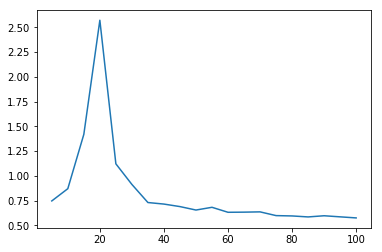

In [110]:
from sklearn.metrics import mean_squared_error

def fix(x):
    x[x > 4] = 4
    x[x < -2] = -2

BATCH_SIZE = 5
steps = []
errors = []
for t in range(BATCH_SIZE, pig.getnnz() + 1, BATCH_SIZE):
    steps.append(t)
    work_ids = pig.indices[:t]
    ratings = pig.data[:t]
    gpr.fit(als.VT.T[work_ids], ratings)
    y_pred = gpr.predict(als.VT.T[pig.indices])
    fix(y_pred)
    rmse = mean_squared_error(pig.data, y_pred) ** 0.5
    errors.append(rmse)
    print(t, 'rmse', rmse)
    print(y_pred[:5], pig.data[:5])
    #print(y_pred)
    #print(pig.data)
    #print(pig.indices[y_pred > 10])
plt.plot(steps, errors)

In [111]:
guilty = pig.indices[y_pred > 10]

In [112]:
pig.data[y_pred > 10]

array([], dtype=float64)

/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


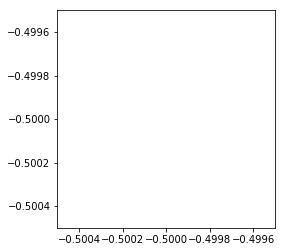

In [114]:
plt.imshow(np.cov(als.VT.T[guilty]))

In [115]:
gpr.kernel_

0.316**2 * DotProduct(sigma_0=0.9)

In [116]:
gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': 0.316**2 * DotProduct(sigma_0=0.9),
 'kernel__k1': 0.316**2,
 'kernel__k1__constant_value': 0.1,
 'kernel__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k2': DotProduct(sigma_0=0.9),
 'kernel__k2__sigma_0': 0.9,
 'kernel__k2__sigma_0_bounds': (1e-05, 100000.0),
 'n_restarts_optimizer': 0,
 'normalize_y': True,
 'optimizer': None,
 'random_state': None}

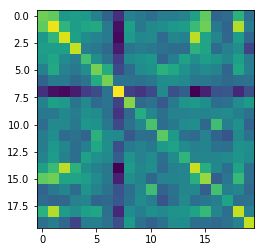

In [117]:
#np.linalg.det()
cov = np.cov(als.VT.T[pig.indices[:20]])
plt.imshow(cov)

In [118]:
cov[7, :]

array([-0.04324693, -0.0654047 , -0.07023251, -0.05788303, -0.03246615,
       -0.02028894,  0.01596553,  0.1666506 , -0.02917402, -0.03943211,
       -0.02256469,  0.03953234, -0.01692961, -0.00287952, -0.07616222,
       -0.05413225, -0.01386519, -0.01049249, -0.04917719, -0.01708599])

In [119]:
cov[1, :]

array([ 0.10772348,  0.1599239 ,  0.08245079,  0.06021867,  0.06670452,
        0.07055525,  0.02440402, -0.0654047 ,  0.06170228,  0.02071746,
        0.03780755,  0.04305861,  0.05331147,  0.05684537,  0.08930027,
        0.11285103,  0.02181251,  0.00325082,  0.13864394,  0.02551144])

In [120]:
pig.indices[[1, 18]]

array([ 1, 60], dtype=int32)

## Linear kernel

In [121]:
from mangaki.utils.dpp2 import MangakiDPP

rated = als.VT.T[pig.indices]
dpp = MangakiDPP(vectors=rated)
dpp.compute_similarity(kernel)
dpp.preprocess()

In [122]:
dpp.sample_k(5)

array([24, 78, 40, 27, 70])

In [123]:
len(i_test)

415

In [124]:
all_vectors = als.VT.T[pig.indices]

def bgs(nb_questions):
    global all_vectors
    rated_works = range(pig.getnnz())
    P = all_vectors[rated_works].dot(all_vectors[rated_works].T)
    nb_works = len(rated_works)
    # print(nb_works, nb_questions)
    kept_indices = set(range(nb_works))
    for _ in range(nb_works - nb_questions):
        k_min = None
        error_min = float('inf')
        for k in kept_indices:
            kept = list(kept_indices - set([k]))
            try:
                #error = np.trace(np.linalg.inv(P[np.ix_(kept, kept)]))
                #error = 1 / compute_score(kept, 'det')
                error = np.linalg.det(np.linalg.inv(P[np.ix_(kept, kept)]))
            except:
                print('I had to take', nb_questions, 'but I must stop at', len(kept_indices))
                return list(kept_indices)
            if error < error_min:
                error_min = error
                k_min = k
        kept_indices -= set([k_min])
    sampled_indices = list(kept_indices)
    return np.array(sampled_indices)

In [125]:
bgs(5)

/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


array([ 70,  83,  93,  97, 103])

/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


2 bgs rmse 1.20459856064
2 dpp rmse 0.901974330182
4 bgs rmse 0.817718951951
4 dpp rmse 0.745240863763
6 bgs rmse 0.934573621233
6 dpp rmse 0.713974742477
8 bgs rmse 1.04368582677
8 dpp rmse 0.761847991505
10 bgs rmse 1.0525071394
10 dpp rmse 0.886099837173
12 bgs rmse 1.09886955607
12 dpp rmse 0.896087133108
14 bgs rmse 1.07596580273
14 dpp rmse 0.873953489742
16 bgs rmse 1.4785504352
16 dpp rmse 0.936972870008
18 bgs rmse 1.64424772212
18 dpp rmse 0.847927803148
20 bgs rmse 2.82600480598
20 dpp rmse 1.01754738568


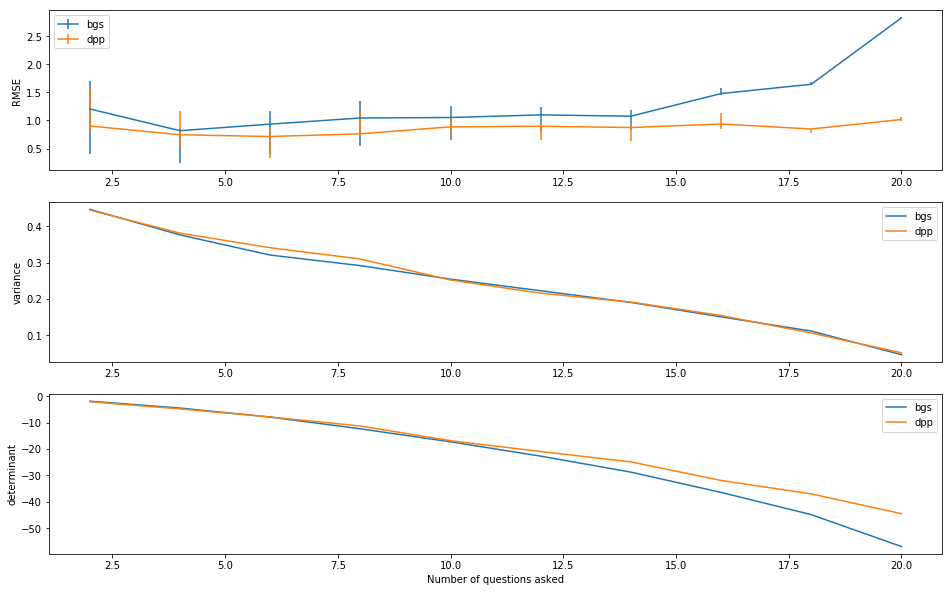

In [73]:
import random
from collections import defaultdict

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

STRATEGIES = ['bgs', 'dpp'] # , 'random

#gpr = GaussianProcessRegressor(kernel=0.1 * kernel)
BATCH_SIZE = 40
steps = []
values = defaultdict(lambda: defaultdict(list))
#sigmas = defaultdict(list)
#errors = defaultdict(list)
#errors_min = defaultdict(list)
#errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in list(range(2, 21, 2)):
    steps.append(nb_rated)
    for strategy in STRATEGIES:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        elif strategy == 'dpp':
            pos = dpp.sample_k(nb_rated)
        else:
            pos = bgs(nb_rated)
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        X_asked = als.VT.T[work_ids]
        values['det'][strategy].append(np.log(np.linalg.det(kernel(X_asked))))
        
        gpr.fit(X_asked, ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_up = abs(rmse - mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5)
        rmse_down = abs(rmse - mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5)
        values['sigma'][strategy].append(sigma.mean())
        values['rmse'][strategy].append(rmse)
        values['rmse_up'][strategy].append(rmse_up)
        values['rmse_down'][strategy].append(rmse_down)
        print(nb_rated, strategy, 'rmse', rmse)
        #print(y_pred[:5], pig.data[:5])
curves = defaultdict(list)
#sigma_curves = []
for strategy in STRATEGIES:
    for value in ['sigma', 'det']:
        curves[value].append(plot[value].errorbar(steps, values[value][strategy], label=strategy))
    curves['rmse'].append(plot['rmse'].errorbar(steps, values['rmse'][strategy],
                                                yerr=[values['rmse_down'][strategy], values['rmse_up'][strategy]],
                                                label=strategy))
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

## RBF kernel

In [ ]:
from sklearn.gaussian_process.kernels import RBF

In [ ]:
rated = als.VT.T[pig.indices]
rbf = RBF()
dpprbf = MangakiDPP(vectors=rated)
dpprbf.L = rbf(dpprbf.vectors)
dpprbf.preprocess()

5 random rmse 1.6270344761
[ 0.86531955  0.70333149  0.79260592  0.88690749  0.92876861] [ 2.   0.1  0.1  2.   0.1]
5 dpp rmse 1.71099387963
[ 0.63912271  0.8910974   0.61973338  2.73586292  2.7038603 ] [ 2.   0.1  0.1  2.   0.1]
10 random rmse 1.75939426098
[ 0.11001701  0.18415077  0.1         0.25069322  0.25265116] [ 2.   0.1  0.1  2.   0.1]
10 dpp rmse 1.90534313051
[ 1.73340162  1.33753637  1.45665209  3.1725717   3.41254705] [ 2.   0.1  0.1  2.   0.1]
20 random rmse 1.44856000153
[ 2.          0.80399119  0.1         0.28785416  0.4658038 ] [ 2.   0.1  0.1  2.   0.1]
20 dpp rmse 1.59686545526
[ 2.          0.1         1.22820195  2.03961057  2.31972674] [ 2.   0.1  0.1  2.   0.1]
50 random rmse 1.04633350583
[-1.02865449  0.14984586  0.1         2.          0.1       ] [ 2.   0.1  0.1  2.   0.1]
50 dpp rmse 0.996481075795
[ 2.          0.1         0.1         0.31791444  0.1       ] [ 2.   0.1  0.1  2.   0.1]


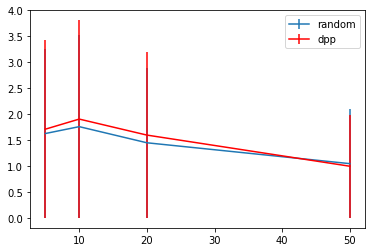

In [29]:
import random
from collections import defaultdict

kernel = DotProduct()
gpr = GaussianProcessRegressor()
BATCH_SIZE = 40
steps = []
errors = defaultdict(list)
errors_min = defaultdict(list)
errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in [5, 10, 20, 50]:
    steps.append(nb_rated)
    for strategy in ['random', 'dpp']:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        else:
            pos = dpprbf.sample_k(nb_rated)
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        
        gpr.fit(als.VT.T[work_ids], ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
        rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
        errors[strategy].append(rmse)
        errors_max[strategy].append(rmse)
        errors_min[strategy].append(rmse)
        print(nb_rated, strategy, 'rmse', rmse)
        print(y_pred[:5], pig.data[:5])
rand_curve = plt.errorbar(steps, errors['random'], yerr=[errors_min['random'], errors_max['random']], label='random')
dpp_curve = plt.errorbar(steps, errors['dpp'], yerr=[errors_min['dpp'], errors_max['dpp']], color='r', label='dpp')
plt.legend(handles=[rand_curve, dpp_curve])
plt.show()

In [201]:
X = np.random.random((5, 2))*100
eig, _ = np.linalg.eig(X.dot(X.T))

In [204]:
np.round(eig)

array([ 18630.,     -0.,   3416.,      0.,     -0.])